# DATA 200 Final Project (Peng Gu, Xi Chen, Kewei Sui)

In [1]:
# import all packages
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

In [2]:
# import all datasets
df_player = pd.read_csv('dataset/2012-18_playerBoxScore.csv')
df_allnbatm = pd.read_csv('dataset/2012-18_all_nba_team.csv',encoding='latin-1')
df_player['gmDate'] = pd.to_datetime(df_player['gmDate'], format='%Y-%m-%d')
df_allnbatm.head(10)

,name,year,position,team,sub_team
0,LeBron James,2012,F,Miami Heat,1
1,Kevin Durant,2012,F,Oklahoma City Thunder,1
2,Tim Duncan,2012,C,San Antonio Spurs,1
3,Kobe Bryant,2012,G,Los AngelesÊLakers,1
4,Chris Paul,2012,G,L.A. Clippers,1
5,Carmelo Anthony,2012,F,New York Knicks,2
6,Blake Griffin,2012,F,L.A. Clippers,2
7,Marc Gasol,2012,C,Memphis Grizzlies,2
8,Tony Parker,2012,G,San Antonio Spurs,2
9,Russell Westbrook,2012,G,Oklahoma City Thunder,2


In [3]:
# We set the number of NBA season based on the game date and the start date of each season in 2012-18
start_dates = ['2012-10-30', '2013-10-29', '2014-10-28', '2015-10-27','2016-10-25','2017-10-17','2018-10-16']
for i in range(len(start_dates)):
    start_dates[i] = datetime.datetime.strptime(start_dates[i],'%Y-%m-%d')

def setSeasons(gm_date):
    for i in range(len(start_dates) - 1):
        if gm_date >= start_dates[i] and gm_date < start_dates[i + 1]:
            return start_dates[i].year

df_player["seasYear"] = df_player['gmDate'].apply(lambda x:setSeasons(x))

In [4]:
# We find out in the dataset "2012-18_playerBoxScore.csv", and there is no data for the pre or post season
# Thus, we will only evaluate players based on their performances in the regular season
df_player = df_player[df_player.seasTyp != 'Pre']
df_player = df_player[df_player.seasTyp != 'Post']

In [5]:
df_player['playFIC40'] = ((df_player['playPTS'] + df_player['playORB'] + 0.75 * df_player['playDRB'] + df_player['playAST'] + df_player['playSTL'] + df_player['playBLK']
- 0.75 * df_player['playFGA'] - 0.375 * df_player['playFTA'] - df_player['playTO'] - 0.5 * df_player['playPF']) * 40 * 5) / df_player['playMin']

In [6]:
df_player.isnull().sum()

gmDate          0
gmTime          0
seasTyp         0
playLNm         0
playFNm         0
teamAbbr        0
teamConf        0
teamDiv         0
teamLoc         0
teamRslt        0
teamDayOff      0
offLNm1         0
offFNm1         0
offLNm2         0
offFNm2         0
offLNm3        41
offFNm3        41
playDispNm      0
playStat        0
playMin         0
playPos         0
playHeight      0
playWeight      0
playBDate       0
playPTS         0
playAST         0
playTO          0
playSTL         0
playBLK         0
playPF          0
playFGA         0
playFGM         0
playFG%         0
play2PA         0
play2PM         0
play2P%         0
play3PA         0
play3PM         0
play3P%         0
playFTA         0
playFTM         0
playFT%         0
playORB         0
playDRB         0
playTRB         0
opptAbbr        0
opptConf        0
opptDiv         0
opptLoc         0
opptRslt        0
opptDayOff      0
seasYear        0
playFIC40     412
dtype: int64

In [7]:
# Data cleaning
df_player['offLNm3'] = df_player['offLNm3'].fillna(df_player['offLNm2'])
df_player['offFNm3'] = df_player['offFNm3'].fillna(df_player['offFNm2'])
df_player['playFIC40'] = df_player['playFIC40'].fillna(0.0)

In [8]:
# Data cleaning
df_player = df_player.drop(columns=['teamDiv', 'teamDayOff', 'offLNm1', 'offFNm1', 'offLNm2', 'offFNm2', \
      'offLNm3', 'offFNm3', 'opptDiv', 'opptDayOff'])

In [9]:
df_player["playPos"] = df_player["playPos"] .replace({'PG':'G', 'SG':'G', 'SF':'F', 'PF':'F'})
df_player.head()

,gmDate,gmTime,seasTyp,playLNm,playFNm,teamAbbr,teamConf,teamLoc,teamRslt,playDispNm,...,playFT%,playORB,playDRB,playTRB,opptAbbr,opptConf,opptLoc,opptRslt,seasYear,playFIC40
0,2012-10-30,19:00,Regular,Price,A.J.,WAS,East,Away,Loss,A.J. Price,...,1.0,1,1,2,CLE,East,Home,Win,2012,21.551724
1,2012-10-30,19:00,Regular,Ariza,Trevor,WAS,East,Away,Loss,Trevor Ariza,...,0.5,1,2,3,CLE,East,Home,Win,2012,110.000000
2,2012-10-30,19:00,Regular,Okafor,Emeka,WAS,East,Away,Loss,Emeka Okafor,...,0.5,5,2,7,CLE,East,Home,Win,2012,80.000000
3,2012-10-30,19:00,Regular,Beal,Bradley,WAS,East,Away,Loss,Bradley Beal,...,1.0,0,3,3,CLE,East,Home,Win,2012,45.454545
4,2012-10-30,19:00,Regular,Booker,Trevor,WAS,East,Away,Loss,Trevor Booker,...,0.0,1,0,1,CLE,East,Home,Win,2012,-55.882353


In [10]:
player_starter_bench = pd.pivot_table(data=df_player, index=['playDispNm','seasYear'],columns='playStat',values='teamAbbr',aggfunc='count')
player_starter_bench = player_starter_bench.fillna(0).reset_index()
player_starter_bench.head(10)

playStat,playDispNm,seasYear,Bench,Starter
0,A.J. Hammons,2016,22.0,0.0
1,A.J. Price,2012,35.0,22.0
2,A.J. Price,2013,28.0,0.0
3,A.J. Price,2014,26.0,0.0
4,Aaron Brooks,2012,33.0,20.0
5,Aaron Brooks,2013,60.0,12.0
6,Aaron Brooks,2014,61.0,21.0
7,Aaron Brooks,2015,69.0,0.0
8,Aaron Brooks,2016,65.0,0.0
9,Aaron Brooks,2017,31.0,1.0


In [11]:
# EDA
allnba_starter_bench = player_starter_bench.merge(right=df_allnbatm, how='inner', left_on=['playDispNm', 'seasYear'], right_on=['name','year'])
allnba_starter_bench.drop(columns=['name', 'year'], inplace=True)
allnba_starter_bench.sort_values(by=['seasYear', 'sub_team'], inplace=True, ascending=True)
allnba_starter_bench

,playDispNm,seasYear,Bench,Starter,position,team,sub_team
9,Chris Paul,2012,0.0,70.0,G,L.A. Clippers,1
42,Kevin Durant,2012,0.0,81.0,F,Oklahoma City Thunder,1
50,Kobe Bryant,2012,0.0,78.0,G,Los AngelesÊLakers,1
57,LeBron James,2012,0.0,76.0,F,Miami Heat,1
79,Tim Duncan,2012,0.0,69.0,C,San Antonio Spurs,1
...,...,...,...,...,...,...,...
35,Jimmy Butler,2017,0.0,59.0,F,Minnesota Timberwolves,3
39,Karl-Anthony Towns,2017,0.0,82.0,C,Minnesota Timberwolves,3
68,Paul George,2017,0.0,79.0,F,Oklahoma City Thunder,3
78,Stephen Curry,2017,0.0,51.0,G,Golden State Warriors,3


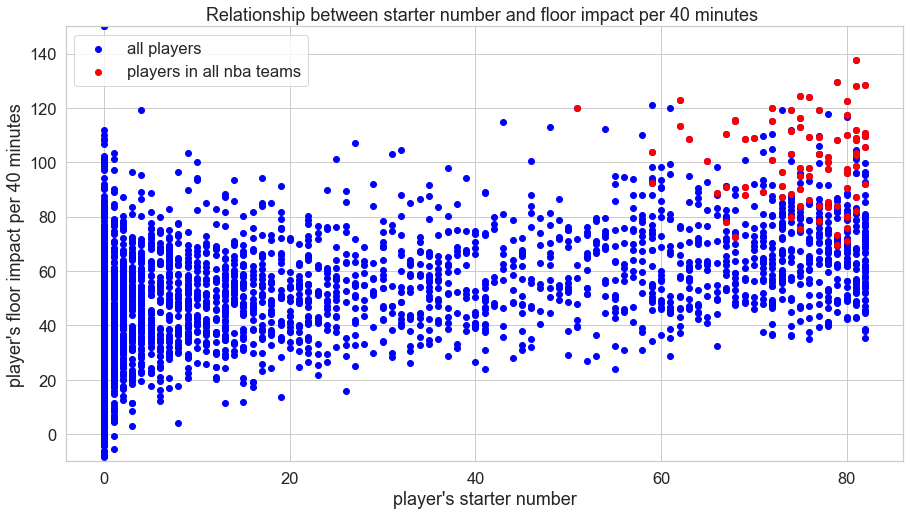

In [12]:

df_player_starter_vs_FIC40 = df_player[['playDispNm', 'playFIC40', 'seasYear']].groupby(["playDispNm", "seasYear"]).mean()
df_player_starter_vs_FIC40 = df_player_starter_vs_FIC40.merge(player_starter_bench, on=['playDispNm', 'seasYear'], how='inner')

#df_2012 = df[df["seasYear"] == 2012]
#allnba_2012 = allnba_regular_starter_bench[allnba_regular_starter_bench["seasYear"] == 2012]

plt.figure(figsize=(15,8))
plt.ylim(-10, 150)
plt.title("Relationship between starter number and floor impact per 40 minutes ")
plt.xlabel("player's starter number")
plt.ylabel("player's floor impact per 40 minutes")

df_allnba_starter_vs_FIC40 = df_player_starter_vs_FIC40.merge(allnba_starter_bench, on=["playDispNm", "seasYear", "Bench", "Starter"])

plt.scatter(df_player_starter_vs_FIC40['Starter'], df_player_starter_vs_FIC40["playFIC40"], color='blue', label="all players")
plt.scatter(df_allnba_starter_vs_FIC40['Starter'], df_allnba_starter_vs_FIC40['playFIC40'], color='red', label="players in all nba teams")
plt.legend();